# Calculate Statistics for Multiple Models per Year

Word2Vec is an unstable model as they arbitrarily generate word vectors [10.1007/s00799-019-00271-6](http://doi.org/10.1007/s00799-019-00271-6).
This means word vectors from two different word2vec models cannot be compared directly.
A way to fix this issue is to perform a task called alignment, which involves aligning multiple word2vec models onto the same vector space.
The approach to align word vector models is called orthogonal procrustes, which is a linear algebra technique that aligns two vector spaces while preserving the orthogonal property of vectors.
This notebook designed to confirm that the alignment step works for these models.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from gensim.models import Word2Vec, KeyedVectors
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import plotnine as p9
from plydata import define, select, group_by, do, ungroup, query, arrange
import tqdm
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.word2vec_analysis_helper import align_word2vec_models

# Load Word2Vec model

In [2]:
word_models = list(Path("output/models").rglob("*model"))
word_models = sorted(word_models, key=lambda x: x.stem)
word_model_filter = list(filter(lambda x: "2001" in x.stem, word_models))

In [3]:
words_to_visualize = []
most_frequent_tokens = []

In [4]:
for model_file in tqdm.tqdm(word_model_filter):
    word_model = Word2Vec.load(str(model_file))
    most_frequent_tokens.append(
        {word: word_model.wv[word] for word in word_model.wv.index_to_key[:100]}
    )
    words_to_visualize.append(np.array(word_model.wv.vectors))

words_to_visualize = np.vstack(words_to_visualize)

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


# Train the UMAP model on Unaligned Vectors

In [5]:
file_name = "output/umap_models/2001_no_alignment"
tokens = list(most_frequent_tokens[0].keys())
words_subset = np.vstack(
    list(map(lambda x: np.vstack(list(x.values())), most_frequent_tokens))
)

In [6]:
if not Path(file_name).exists():
    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.0,
    )
    model.fit(words_to_visualize)
    embedding = model.transform(words_subset)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
    embedding = model.transform(words_subset)

Pickle of ParametricUMAP model loaded from output/umap_models/2001_no_alignment/model.pkl
Keras encoder model loaded from output/umap_models/2001_no_alignment/encoder
Keras full model loaded from output/umap_models/2001_no_alignment/parametric_model


In [7]:
mapped_df = (
    pd.DataFrame(embedding, columns=["umap1", "umap2"])
    >> define(token=tokens * 10)
    >> define(
        model_iter=sorted(list(range(10)) * len(tokens))
    )  # copy each model iter for each token num
)
mapped_df.model_iter = pd.Categorical(mapped_df.model_iter)
mapped_df.head()

,umap1,umap2,token,model_iter
0,-39.697086,52.691490,,0
1,-39.308723,53.457123,the,0
2,-39.493725,53.485962,of,0
3,-39.444927,53.152515,",",0
4,-39.449097,53.392029,.,0


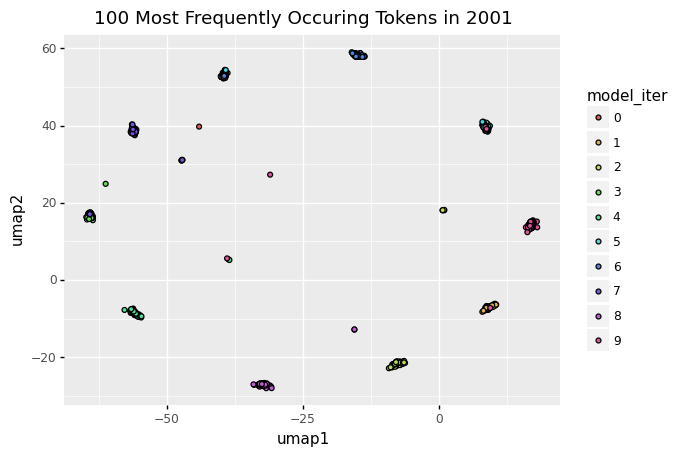

In [8]:
g = (
    p9.ggplot(mapped_df, p9.aes(x="umap1", y="umap2", fill="model_iter"))
    + p9.geom_point()
    + p9.labs(title="100 Most Frequently Occuring Tokens in 2001")
)
print(g)

# Train UMAP Model on Aligned Vectors

In [9]:
base_model = Word2Vec.load(str(word_models[-1]))
words_to_visualize = []
most_frequent_tokens = []

In [10]:
for model_file in tqdm.tqdm(word_model_filter):
    word_model = Word2Vec.load(str(model_file))
    aligned_model = align_word2vec_models(base_model, word_model)
    most_frequent_tokens.append(
        {word: aligned_model.wv[word] for word in aligned_model.wv.index_to_key[:100]}
    )
    words_to_visualize.append(np.array(aligned_model.wv.vectors))

words_to_visualize = np.vstack(words_to_visualize)

100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


In [11]:
file_name = "output/umap_models/2001_with_alignment"
tokens = list(most_frequent_tokens[0].keys())
words_subset = np.vstack(
    list(map(lambda x: np.vstack(list(x.values())), most_frequent_tokens))
)

In [12]:
if not Path(file_name).exists():
    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.0,
    )
    model.fit(words_to_visualize)
    embedding = model.transform(words_subset)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
    embedding = model.transform(words_subset)

Epoch 1/10
21976/21976 [==============================] - 535s 24ms/step - loss: 0.2800
Epoch 2/10
21976/21976 [==============================] - 548s 25ms/step - loss: 0.2532
Epoch 3/10
21976/21976 [==============================] - 542s 25ms/step - loss: 0.2504
Epoch 4/10
21976/21976 [==============================] - 554s 25ms/step - loss: 0.2487
Epoch 5/10
21976/21976 [==============================] - 542s 25ms/step - loss: 0.2476
Epoch 6/10
21976/21976 [==============================] - 537s 24ms/step - loss: 0.2465
Epoch 7/10
21976/21976 [==============================] - 540s 25ms/step - loss: 0.2459
Epoch 8/10
21976/21976 [==============================] - 536s 24ms/step - loss: 0.2454
Epoch 9/10
21976/21976 [==============================] - 537s 24ms/step - loss: 0.2449
Epoch 10/10
21976/21976 [==============================] - 536s 24ms/step - loss: 0.2444
INFO:tensorflow:Assets written to: output/umap_models/2001_with_alignment/encoder/assets
Keras encoder model saved to o

In [13]:
mapped_df = (
    pd.DataFrame(embedding, columns=["umap1", "umap2"])
    >> define(token=tokens * 10)
    >> define(
        model_iter=sorted(list(range(10)) * len(tokens))
    )  # copy each model iter for each token num
)
mapped_df.model_iter = pd.Categorical(mapped_df.model_iter)
mapped_df.head()

,umap1,umap2,token,model_iter
0,-0.731570,-1.903317,the,0
1,-0.899124,2.624090,",",0
2,-2.155193,0.152159,,0
3,3.397995,5.019551,.,0
4,3.268952,5.165972,of,0


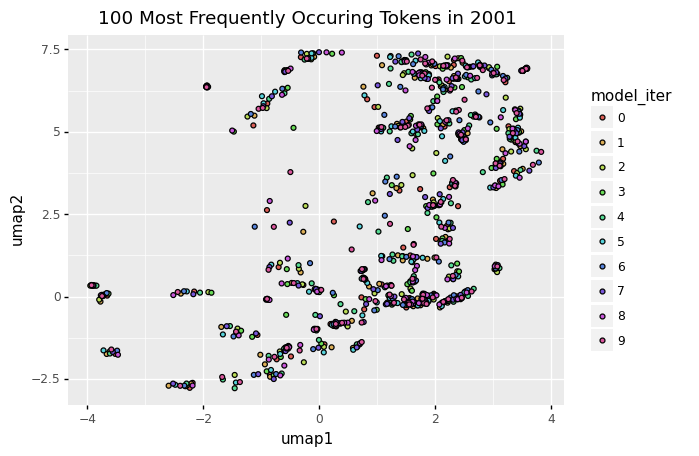

In [14]:
g = (
    p9.ggplot(mapped_df, p9.aes(x="umap1", y="umap2", fill="model_iter"))
    + p9.geom_point()
    + p9.labs(title="100 Most Frequently Occuring Tokens in 2001")
)
print(g)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


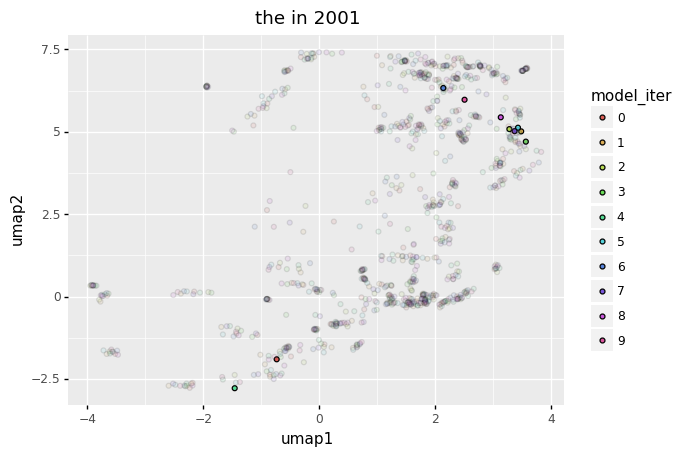

In [27]:
g = (
    p9.ggplot(
        mapped_df >> define(opacity=lambda x: x.token == "the"),
        p9.aes(x="umap1", y="umap2", fill="model_iter", alpha="opacity"),
    )
    + p9.geom_point()
    + p9.labs(title="the in 2001")
    + p9.guides(alpha=False)
)
print(g)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


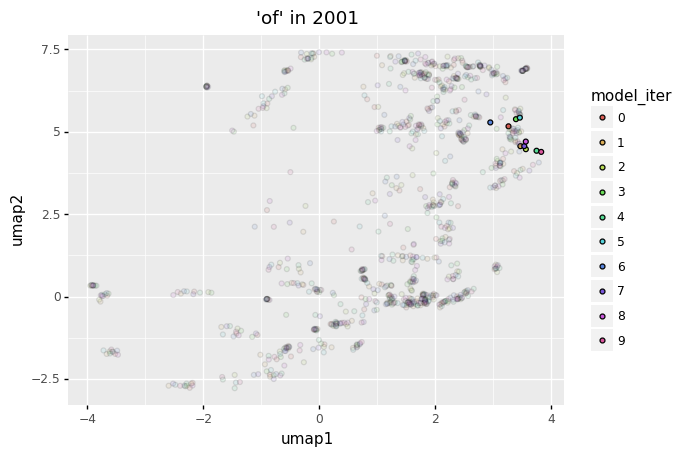

In [28]:
g = (
    p9.ggplot(
        mapped_df >> define(opacity=lambda x: x.token == "of"),
        p9.aes(x="umap1", y="umap2", fill="model_iter", alpha="opacity"),
    )
    + p9.geom_point()
    + p9.labs(title="'of' in 2001")
    + p9.guides(alpha=False)
)
print(g)